### VIZ

In [17]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## Load Datas

In [18]:
# path = pd.DataFrame(glob(r'dataPVC/*'))
# path.columns = ['data']
# path[0:5]

# for i in range (len(path)):
#     a = loadmat(path[i])

path = pd.DataFrame(glob(r'dataPVC/*'))
path.columns = ['data']

load = loadmat(path['data'][0])
dados = load['DAT'][0]
df_dados = pd.DataFrame(dados)

ecg_array = np.array(df_dados['ecg'][0])
ind_array = np.array(df_dados['ind'][0])
pvc_array = np.array(df_dados['pvc'][0])

# Mudança de formatos de array de nested array para array com ints
ecg_array = np.array([x[0] for x in ecg_array])
ind_array = np.array([x[0] for x in ind_array])
pvc_array = np.array([x[0] for x in pvc_array])




sample_rate = 360
time_ecg = (round(len(ecg_array)/sample_rate))
min_ecg = time_ecg/60

dados

array([(array([[ 972],
              [ 972],
              [ 972],
              ...,
              [ 920],
              [1024],
              [1024]], dtype=uint16), array([[    14],
              [    24],
              [    99],
              ...,
              [649237],
              [649448],
              [649777]], dtype=int32), array([[0],
              [0],
              [0],
              ...,
              [0],
              [0],
              [0]], dtype=uint8))                     ],
      dtype=[('ecg', 'O'), ('ind', 'O'), ('pvc', 'O')])

### Loading só ao primeiro paciente para realizar as operações necessárias unicamente nele

In [20]:
load = loadmat(path['data'][0])
dados = load['DAT'][0]
print(dados)
df_dados = pd.DataFrame(dados)
ecg_array = np.array(df_dados['ecg'][0])
ind_array = np.array(df_dados['ind'][0])
pvc_array = np.array(df_dados['pvc'][0])

# Mudança de formatos de array de nested array para array com ints
ecg_array = np.array([x[0] for x in ecg_array])
ind_array = np.array([x[0] for x in ind_array])
pvc_array = np.array([x[0] for x in pvc_array])




sample_rate = 360
time_ecg = (round(len(ecg_array)/sample_rate))
min_ecg = time_ecg/60

print (f'There are %s patients in out dataset.' %(len(path)))
print (f'Our patients have approximately %s seconds of ECG' %(time_ecg))
print (f'Neste paciente existem %s beats e consequentemente %s bpm' %(len(ind_array), round(len(ind_array)/min_ecg)))


[(array([[ 972],
        [ 972],
        [ 972],
        ...,
        [ 920],
        [1024],
        [1024]], dtype=uint16), array([[    14],
        [    24],
        [    99],
        ...,
        [649237],
        [649448],
        [649777]], dtype=int32), array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8))                     ]
There are 11 patients in out dataset.
Our patients have approximately 1806 seconds of ECG
Neste paciente existem 3107 beats e consequentemente 103 bpm


## Len ind == Len pvc == nº R Peaks == nº Beats

### Atualmente não está a ser usado!

In [21]:
# def pvc_quantity(array):
#     count = 0
#     for num in array:
#         if num == 1:
#             count+=1
#     return count

# num_pvc = (pvc_quantity(pvc_array))

## Normalizacao dos dados (0 a 10)

In [22]:
max = ecg_array.max()
min = ecg_array.min()

# Normalize Data
norm_ecg = np.array([(x-min)/(max-min)*10 for x in ecg_array])

In [24]:
ind_array[40]-100

7487

### Tentativa de smoothing para remover o máximo de ruído possível

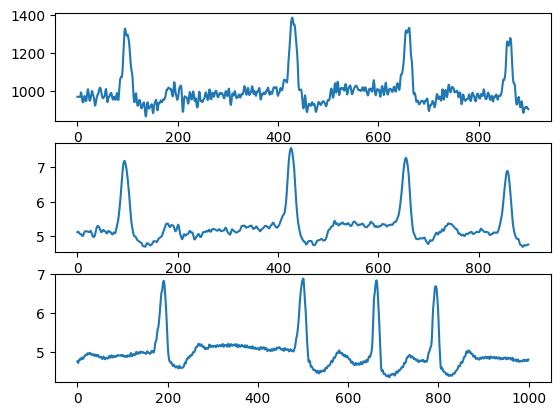

In [25]:
# Define smoothing window size
window_size = 8

# Apply moving average filter to ECG signal
smoothed_ecg = np.convolve(norm_ecg.flatten(), np.ones((window_size,))/window_size, mode='valid')

fig, axs = plt.subplots(3)
axs[0].plot (ecg_array[0:900])
axs[1].plot (smoothed_ecg[0:900])
axs[2].plot (norm_ecg[ind_array[40]-500:ind_array[40]+500])
# axs[3].plot (norm_ecg[000:900])

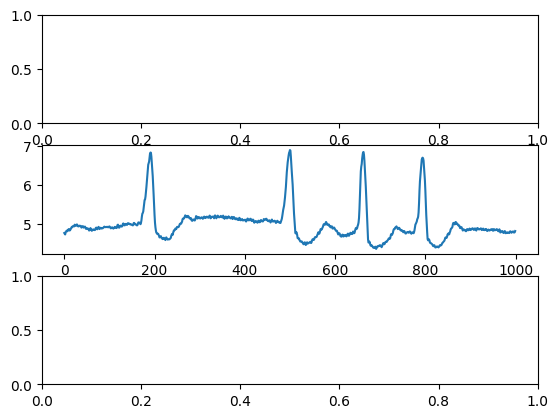

In [26]:

fig, axs = plt.subplots(3)
axs[1].plot (norm_ecg[ind_array[40]-500:ind_array[40]+500])

## Retirar R Peaks mal definidos
#### Partimos do pressuposto que para ser R-Peak então a amplitude max e min do QRS varia no minimo em 2x <p> como sabemos que um QRS tem entre 0.060s a 0.120s => ~ 20 a 40 samples <p> (consideramos 20 para a esquerda e direita do pico)

In [27]:
from copy import deepcopy

ind_array_clean = deepcopy(ind_array)
pvc_array_clean = deepcopy(pvc_array)

mal_class = []

for i, peak in enumerate(ind_array):
    temp = (norm_ecg[peak-20:peak+20])
    if (temp.max() - temp.min()) < 2:
        mal_class.append(i)

ind_array_clean = np.delete(ind_array_clean, mal_class)
pvc_array_clean = np.delete(pvc_array_clean, mal_class)
print (ind_array_clean)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
lista_diff = []
for i, peak in enumerate(ind_array_clean):
    if i == 0:
        peak2 = peak
        continue
    lista_diff.append(peak - peak2)
    # print(f'peak2 = {peak2}')
    peak2 = peak 
    # print(lista_diff)
    # print(f'peak1 = {peak}' )
    # print ()
mean_lista_diff = np.mean(lista_diff)
std_lista_diff = np.std(lista_diff)
print (f'Average RR is given by {mean_lista_diff} with a standard deviation of +-{std_lista_diff}')

Average RR is given by 324.07185628742513 with a standard deviation of +-101.00588818208769
